In [325]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import requests
import datetime
from collections import namedtuple
from geopy.geocoders import Nominatim

In [557]:
st.title("Find wind in your local area")
col1, col2, col3= st.beta_columns([2,8,1])
with col1:
    st.write("test")
with col2:
    st.write("")
    st.write("test2")
with col3:
    st.markdown("**test**")
    
st.sidebar.markdown("Navigate to:")
choice = st.sidebar.selectbox("", ["Wind forecast","Historical"])

In [326]:
url = "https://raw.githubusercontent.com/nkim500/Metis_Projects/main/07_Engineering/US_stations.csv"
df = pd.read_csv(url)

station_i = namedtuple("station", "usaf wban station_code st_name country state call latitude longitude elevation begin end forecastlink")

In [327]:
stuco = [] 
stations_us = []
idx = 1
for i in range(len(df)):
    stuco.append([str(idx) + " " + str(df["station_code"][i]), df["state"][i], df["call"][i], df["latitude"][i], df["longitude"][i]])
    usaf = df["usaf"][i]
    wban = df["wban"][i]
    station_code = str(idx) + " " + str(df["station_code"][i])
    st_name = df["st_name"][i]
    country = df["country"][i]
    state = df["state"][i]
    call = df["call"][i]
    latitude = df["latitude"][i]
    longitude = df["longitude"][i]
    elevation = df["elevation"][i]
    begin = df["begin"][i]
    end = df["end"][i]
    forecastlink = df["forecast_api_endpoint"][i]
    stations_us.append(station_i(usaf, wban, station_code, st_name, country, state, call, latitude, longitude, elevation, begin, end, forecastlink))
    idx += 1

In [328]:
df_station = pd.DataFrame(stuco, columns=['code', 'state', 'call', 'lat','lon'])

In [329]:
# st.map(data.loc[:,['lat', 'lon']])

In [591]:
import altair as alt

states = alt.topo_feature('https://cdn.jsdelivr.net/npm/vega-datasets@v1.29.0/data/us-10m.json', 'states')

# US states background
background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    title=alt.TitleParams('Map of US weather stations', fontSize=24),
    width=1000,
    height=700
).project('albersUsa')


# Points and text
hover = alt.selection(type='single', on='mouseover', nearest=True,
                      fields=['lat', 'lon'])

# selection = alt.selection_interval(bind='scales')

base = alt.Chart(df_station).encode(
    longitude='lon:Q',
    latitude='lat:Q',
)

text = base.mark_text(dy=-10, align='right', fontSize=18, ).encode(
    alt.Text('code', type='nominal'),
    opacity=alt.condition(~hover, alt.value(0), alt.value(1))
)

points = base.mark_point().encode(
    color=alt.value('steelblue'),
    size=alt.condition(~hover, alt.value(1), alt.value(100))
).add_selection(hover)

background + points + text

alt.LayerChart(...)

In [331]:
user_input = st.text_input("Input station code", "2972 KONA")

In [552]:
def searchstation(user_input):
    for i in stations_us:
        if i.station_code == user_input:
            return i

In [351]:
x = searchstation(user_input)
x

station(usaf='912810', wban=99999, station_code='2972 KONA', st_name='HAWAIIIS.HAWAII', country='US', state=nan, call=nan, latitude=19.65, longitude=-156.0, elevation=9.0, begin=19730620, end=19961009, forecastlink='https://api.weather.gov/gridpoints/HFO/231,70')

In [466]:
def address_gen(station_i):
    geolocator = Nominatim(user_agent="geoapiExercises")

    location = geolocator.reverse((float(station_i.latitude),float(station_i.longitude)))

    # address = location.raw['address']
    
    return(str(location))
    # city = address.get('city', '')
    # state = address.get('state', '')
    # zipcode = address.get('postcode')
    # print(f'{city}, {state} {zipcode}')

In [555]:
def tw_forecast (x):
# api is forecastGridData endpoint e.g. 'https://api.weather.gov/gridpoints/EPZ/106,80'; can be called by stations_us.forecastlink
    api = requests.get(x).json()
    dates_t = []
    dates_wd = []
    dates_ws = []
    output_t = []
    output_wd = []
    output_ws = []

    for i in api['properties']['temperature']['values']:
        date, hour = i['validTime'].split("T")[0], i['validTime'].split("T")[1].split("+")[0]
        dateobject = datetime.datetime.strptime(date + " " + hour, '%Y-%m-%d %H:%M:%S')
        forhowmany = int(i['validTime'].split("T")[2].split("H")[0])
        forecast = round(i['value'],2)
        
        if forhowmany == 1:
            dates_t.append(dateobject)
            output_t.append(forecast)
        else:
            dates_t.append(dateobject)
            output_t.append(forecast)
            while forhowmany > 1:
                dateobject += datetime.timedelta(hours=1)
                dates_t.append(dateobject)
                output_t.append(forecast)
                forhowmany -= 1
                
    for i in api['properties']['windDirection']['values']:
        date, hour = i['validTime'].split("T")[0], i['validTime'].split("T")[1].split("+")[0]
        dateobject = datetime.datetime.strptime(date + " " + hour, '%Y-%m-%d %H:%M:%S')
        forhowmany = int(i['validTime'].split("T")[2].split("H")[0])
        forecast = round(i['value'],2)
        
        if forhowmany == 1:
            dates_wd.append(dateobject)
            output_wd.append(forecast)
        else:
            dates_wd.append(dateobject)
            output_wd.append(forecast)
            while forhowmany > 1:
                dateobject += datetime.timedelta(hours=1)
                dates_wd.append(dateobject)
                output_wd.append(forecast)
                forhowmany -= 1
                
    for i in api['properties']['windSpeed']['values']:
        date, hour = i['validTime'].split("T")[0], i['validTime'].split("T")[1].split("+")[0]
        dateobject = datetime.datetime.strptime(date + " " + hour, '%Y-%m-%d %H:%M:%S')
        forhowmany = int(i['validTime'].split("T")[2].split("H")[0])
        forecast = round(i['value']/1.852,5)
        
        if forhowmany == 1:
            dates_ws.append(dateobject)
            output_ws.append(forecast)
        else:
            dates_ws.append(dateobject)
            output_ws.append(forecast)
            while forhowmany > 1:
                dateobject += datetime.timedelta(hours=1)
                dates_ws.append(dateobject)
                output_ws.append(forecast)
                forhowmany -= 1
    
    return dates_t, dates_ws, dates_wd, output_t, output_ws, output_wd


def distance_calc(a, b):
    R = 3963
    lat1 = math.radians(float(a.latitude))
    lon1 = math.radians(float(a.longitude))
    lat2 = math.radians(float(b.latitude))
    lon2 = math.radians(float(b.longitude))
    
    lat_d = lat1 - lat2
    lon_d = lon1 - lon2

    p = math.sin(lat_d / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(lon_d / 2)**2
    c = 2 * math.atan2(math.sqrt(p), math.sqrt(1 - p))
    
    distance = R * c
    
    return distance

def n_neighbors(input_station, n):
    
    placeholder1 = []
    placeholder2 = []

    for i in stations_us:
        placeholder1.append(i)
        placeholder2.append(distance_calc(input_station,i))

    distances = np.array(placeholder2)
    location_idx = np.argsort(distances)[:n].tolist()

    for i in location_idx:
        try:
            generate_charts(placeholder1[i])
        except KeyError:
            print("Forecast not available for the station")

def generate_charts(station_i):
    
    if len(station_i.forecastlink) < 2:
        print("Forecast not available for the station")
    else:
        tt, tws, twd, temp, winds, windd = tw_forecast(station_i.forecastlink)
        X = np.arange(0, len(windd))
        Y = np.ones(X.shape[0])*50
        # U = [np.cos(math.radians(i)) for i in windd]
        # V = [np.sin(math.radians(i)) for i in windd]
        U = [np.cos(math.radians(i)) if index % 3 == 0 else 0 for index, i in enumerate(windd)]
        V = [np.sin(math.radians(i)) if index % 3 == 0 else 0 for index, i in enumerate(windd)]
        windscore = sum(1 if tws[idx] >= tws[idx].replace(hour=6) and tws[idx] <= tws[idx].replace(hour=20) and i >= 9 else 0 for idx, i in enumerate(winds))/len(winds)
        
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20,8), gridspec_kw = {'height_ratios':[3, 3, 1]})
        fig.suptitle(station_i.station_code + "; " + "Wind score: {:.1%}".format(windscore) + "; " + address_gen(station_i), fontsize=16)
        ax1.set_title("Temperature")
        ax1.scatter(tt, temp)
        ax1.set_ylabel("celsius")
        ax1.margins(x=0)
        ax2.set_title("Wind speed")
        ax2.scatter(tws, winds)
        ax2.axhline(y=9, color = 'lightsteelblue')
        ax2.axhline(y=12, color = 'slategrey')
        ax2.set_ylabel("knots")
        ax2.margins(x=0)
        ax3.set_title("Wind direction")
        ax3.quiver(X, Y, U, V, scale_units = 'x', headwidth = 4, headlength = 4, headaxislength=4, width=0.001, scale=0.5, pivot='tail') 
        ax3.get_xaxis().set_visible(False)
        ax3.get_yaxis().set_visible(False)
        ax3.margins(x=0)
        fig.tight_layout(pad=3)
        fig.subplots_adjust(top=0.9, bottom=0.1)
        st.pyplot(fig);

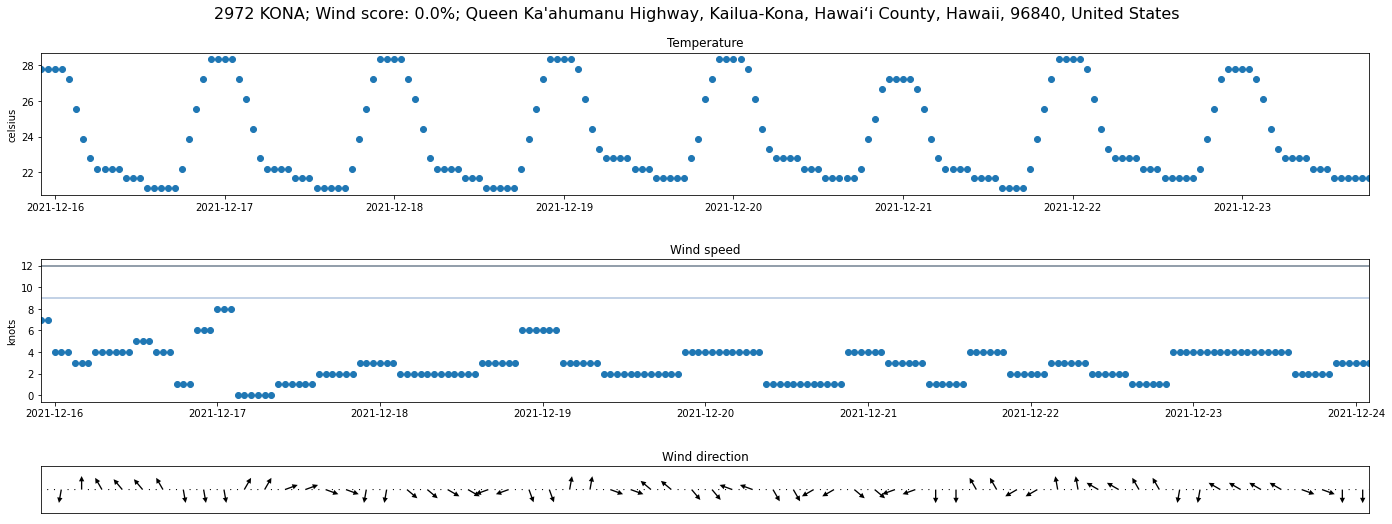

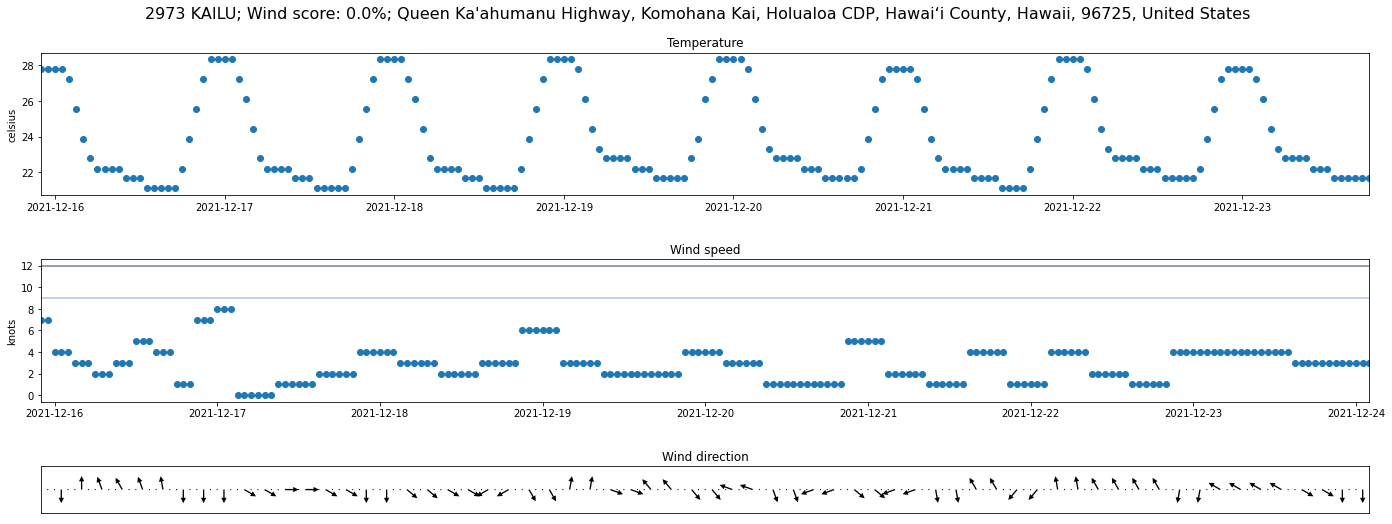

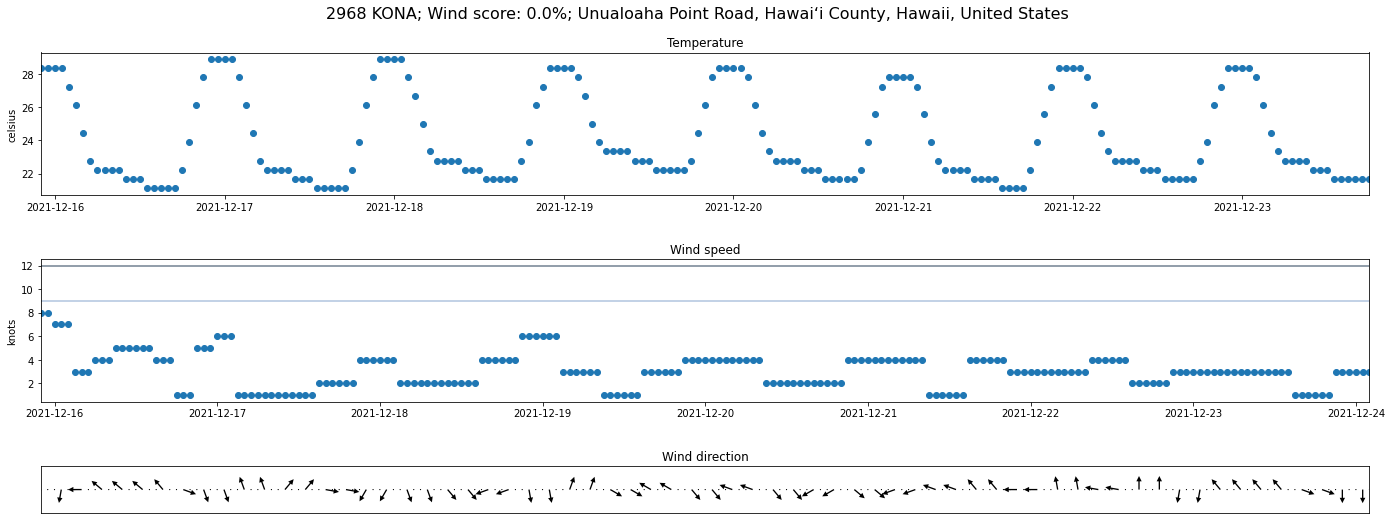

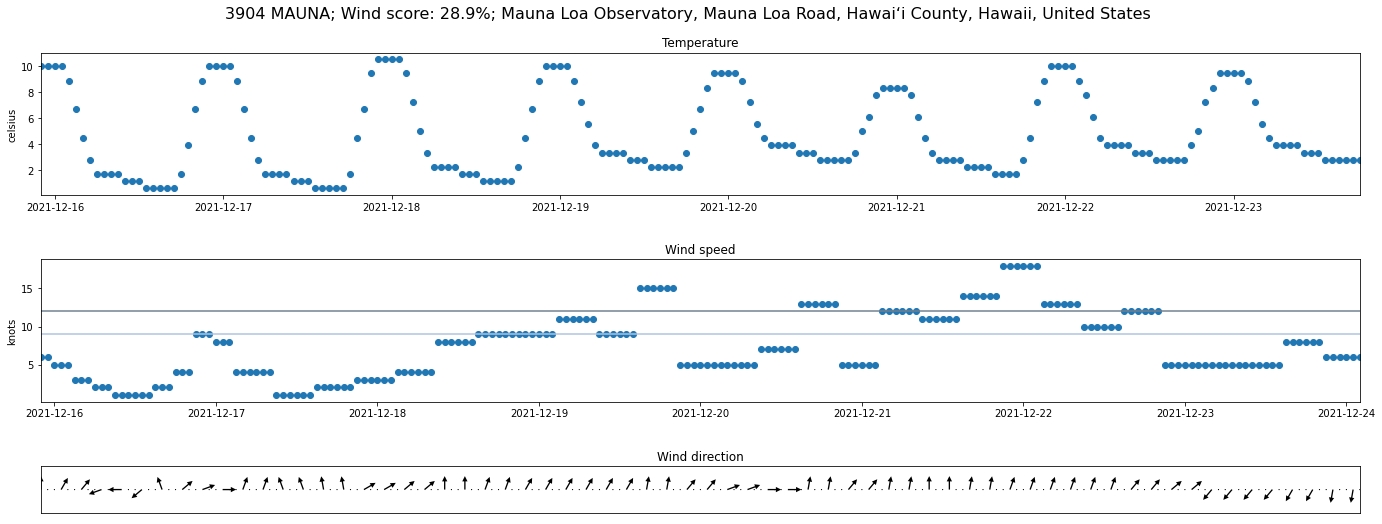

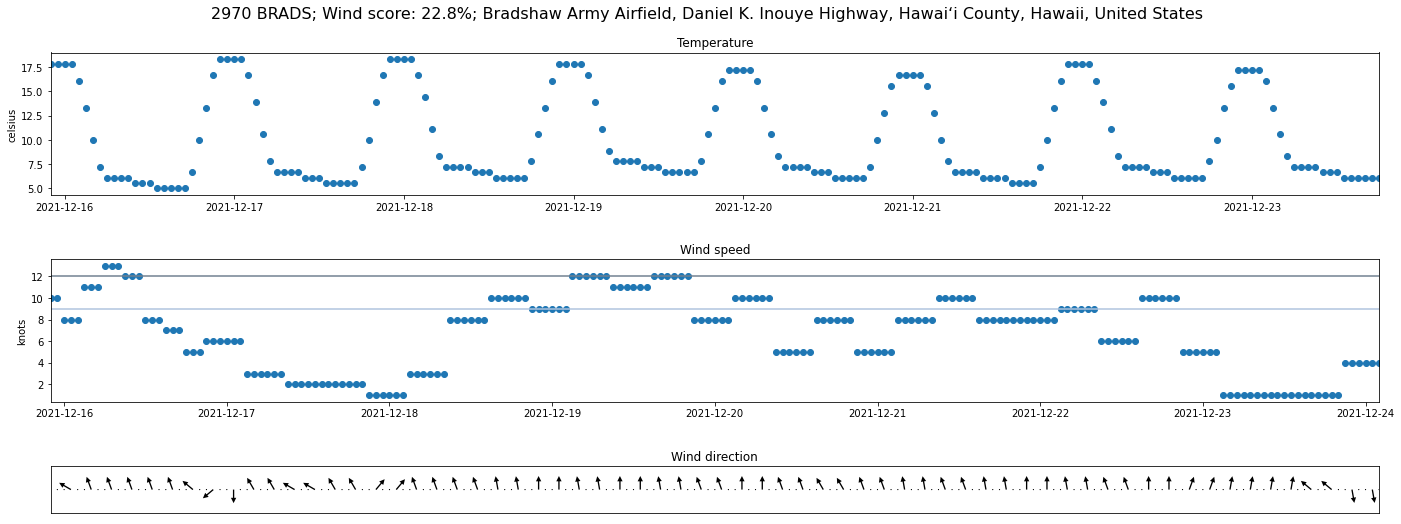

In [556]:
n_neighbors(x,5)

In [558]:
stations_us[525]

station(usaf='720626', wban=213, station_code='526 PAMPA', st_name='MESAVISTAAIRPORT', country='US', state='TX', call='KBPC', latitude=35.883, longitude=-101.033, elevation=845.2, begin=20090326, end=20211208, forecastlink='https://api.weather.gov/gridpoints/AMA/77,53')

In [568]:
call_list = ['KACK','KACY','KBLM','KDLS','KEYW','KFRG','KHSE','KHTO','KJFK','KMIA','KMKG','KOAK','KPIL', 'PHKO']
alias_list = ['Nantucket, MA', 'Ocean City, NJ', 'Sandy Hook Beach, NJ', 'Hood River, OR', 'Key West, FL', 'Gilgo Beach, NY',\
              'Cape Hatteras, Outerbanks, NC', 'East Hampton, NY', 'Plumb Beach, Brookyln, NY','Miami Beach, FL', \
              'Muskegon, MI', 'Crissy Field, San Francisco, CA', 'South Padre Island, TX', 'Kailua Bay, Oahu Island, HI']

In [563]:
def searchstation_c(option):
    for i in stations_us:
        if i.call == option:
            return address_gen(i)

In [569]:
alias_dict = dict(zip(call_list, alias_list))

In [570]:
alias_dict['KACK']

'Nantucket, MA'

In [581]:
alias_coord = []
def coordfind(x):
    for i in stations_us:
        if i.call == x:
            alias_coord.append([i.latitude, i.longitude, i.call, alias_dict[i.call]])

In [582]:
for i in call_list:
    coordfind(i)

In [584]:
df_alias = pd.DataFrame(alias_coord, columns=['lat','lon','call', 'alias'])

In [585]:
df_alias.drop_duplicates(subset=['call'], inplace=True)

In [587]:
background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    title=alt.TitleParams('Well known kitesurfing locations in the US', fontSize=24),
    width=600,
    height=400
).project('albersUsa')


# Points and text
hover = alt.selection(type='single', on='mouseover', nearest=True,
                      fields=['lat', 'lon'])

# selection = alt.selection_interval(bind='scales')

base = alt.Chart(df_alias).encode(
    longitude='lon:Q',
    latitude='lat:Q',
)

text = base.mark_text(dy=-10, align='right', fontSize=18, ).encode(
    alt.Text('alias', type='nominal'),
    opacity=alt.condition(~hover, alt.value(0), alt.value(1))
)

points = base.mark_point().encode(
    color=alt.value('steelblue'),
    size=alt.condition(~hover, alt.value(30), alt.value(100))
).add_selection(hover)

background + points + text

alt.LayerChart(...)